<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-Robusta-para-estimar-tiempo-de-respuesta-de-un-servicio-de-emergencia/blob/main/Notebooks/1_Response_time_Paris_Fire_Brigade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas y funciones

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler         # solamente para la comparación da la improtancia entre variables explicativas

from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def correlacion(dataframe, grafica=True, matrix=True, tamaño =(6, 4)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [4]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'null','nunique','unique' ]
  return(descripcion)

# Lectura datos y selección de características

__Cargar etiquetas__

In [5]:
# Variables respuesta
Ys = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/y_train.csv',
                     index_col=[0], sep=',',)
print(Ys.shape)
Ys.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [6]:
# Se puede verificar si la última columna es la suma de las otras dos
(Ys.iloc[:,0] + Ys.iloc[:,1] == Ys.iloc[:,2]).sum()==len(Ys)

np.True_

Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro

In [7]:
y = Ys['delta departure-presentation']

__Cargar características__

In [8]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/x_train.csv',
                sep=',', index_col=[0], parse_dates=['selection time'] )
print(X.shape)
X.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,...,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,...,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,...,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [9]:
describe_datos(X)

,dtypes,null,nunique,unique
intervention,int64,0,200894,"[13264186, 12663715, 13675521, 12695745, 13698..."
alert reason category,int64,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
alert reason,int64,0,126,"[2162, 2124, 2163, 2112, 2711, 2113, 2135, 212..."
intervention on public roads,int64,0,2,"[0, 1]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,float64,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,83484,"[2.284796, 2.247464, 2.258328, 2.393832, 2.458..."
latitude intervention,float64,0,74503,"[48.879669, 48.818191, 48.836759, 48.776526, 4..."
emergency vehicle,int64,0,749,"[4511, 4327, 4509, 5731, 5623, 4319, 4215, 588..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


La cantidad de intervenciones en los datos no es igual a la cantidad de vehículos, De manera que existen intervenciones que son atendidas por más de un vehiculo de emergencia

el análisis lo vamos a hacer por vehículo

In [10]:
# Borrar columnas que no utilizaremos

col_borrar=['intervention',  #identificador de la intervención

            # Redundantes
            'date key sélection', 'time key sélection', # incluidas en 'selection time'
            'emergency vehicle',  # 749 categorias, que están resumidas en 75 'emergency vehicle type'
            'alert reason', # 126 categorías, que están resumidas en 9 'alert reason category'

            # Variables geográficas
            'OSRM response',                              # rutas
            'GPS tracks departure-presentation',          # rutas
            'GPS tracks datetime departure-presentation', # rutas
            'longitude intervention', 'latitude intervention', # coordenadas
            'longitude before departure',                      # coordenadas
            'latitude before departure',                       # coordenadas

            # Variable no relaccionadas con delta departure-presentation
            'status preceding selection',
            'rescue center', # id 94 centros de rescate, estacionamiento de los vehícuos
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'delta position gps previous departure-departure'
            ]
X = X.drop(columns= col_borrar)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Data columns (total 8 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  int64         
 1   intervention on public roads  219337 non-null  int64         
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  float64       
 4   emergency vehicle type        219337 non-null  object        
 5   selection time                219337 non-null  datetime64[ns]
 6   OSRM estimated distance       219337 non-null  float64       
 7   OSRM estimated duration       219337 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 15.1+ MB


__Unir caracteristicas con étiquetas__

In [11]:
df = pd.concat([X,y], axis=1)
print(df.shape)
df.head(2)

(219337, 9)


,alert reason category,intervention on public roads,floor,location of the event,emergency vehicle type,selection time,OSRM estimated distance,OSRM estimated duration,delta departure-presentation
emergency vehicle selection,,,,,,,,,
5105452,3,0,0,148.0,VSAV BSPP,2018-07-08 19:02:43.990,952.5,105.8,324
4720915,3,0,1,136.0,PSE,2018-01-04 09:02:59.470,2238.5,243.2,297


<h2> Idetificación del tipo de variable de cada columna

Comparamos el tipo de cada columna con la documentación de los parámetros de entrada en [la documentación provista por el Challenge](https://paris-fire-brigade.github.io/data-challenge/challenge.html)

In [12]:
df.dtypes

,0
alert reason category,int64
intervention on public roads,int64
floor,int64
location of the event,float64
emergency vehicle type,object
selection time,datetime64[ns]
OSRM estimated distance,float64
OSRM estimated duration,float64
delta departure-presentation,int64


In [13]:
categoricas=['alert reason category',
             'location of the event',
             'emergency vehicle type']
df[categoricas] = df[categoricas].astype('object')

df['intervention on public roads']=df['intervention on public roads'].astype('bool')
describe_datos(df)

,dtypes,null,nunique,unique
alert reason category,object,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,0,2,"[False, True]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
selection time,datetime64[ns],0,219285,"[2018-07-08 19:02:43.990000, 2018-01-04 09:02:..."
OSRM estimated distance,float64,0,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,0,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
delta departure-presentation,int64,0,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."


# Creación de nuevas variables

<h3>  Creación de variable Rush Hour

Variable binaria para identificar eventos en horas pico

In [14]:
df['rush hour'] = 0

df = df.reset_index( )
df = df.set_index('selection time')

#identificar el indice de los registros de eventos en hora pico
pico_am = df.index.indexer_between_time('6:30','9:30')
pico_pm = df.index.indexer_between_time('16:00','19:00')
horas_pico_index= np.concatenate((pico_am, pico_pm))

#identificar los días sabados y domingos
fin_de_semana_filtro = df.index.weekday > 5  #identifica sábados y domingos

In [15]:
pico_pm

array([    15,     20,     38, ..., 219302, 219314, 219335])

In [16]:
df.iloc[15]

,2018-05-11 18:56:35.320
emergency vehicle selection,4973880
alert reason category,3
intervention on public roads,False
floor,1
location of the event,139.0
emergency vehicle type,PSE
OSRM estimated distance,2305.3
OSRM estimated duration,302.5
delta departure-presentation,346
rush hour,0


In [17]:
# cambiar el valor de 'rush hour' a uno cuando sea horas pico
df.iloc[list(horas_pico_index),-1] = 1

#Regresar a 0 el valor para los días sabados y domingos
df['rush hour']= np.where(fin_de_semana_filtro, 0, df['rush hour'])

<h3> Creación de variable Weekday

Variable binaria para identificar eventos de lunes a viernes

In [18]:
df['weekday'] = np.where(fin_de_semana_filtro, 0, 1)

In [19]:
#Regresar emerency vehicle selection como indice
df = df.reset_index()
df = df.set_index('emergency vehicle selection')

# Manejo de Valores Nulos

In [20]:
print(df.shape)
describe_datos(df)

(219337, 11)


,dtypes,null,nunique,unique
selection time,datetime64[ns],0,219285,"[2018-07-08 19:02:43.990000, 2018-01-04 09:02:..."
alert reason category,object,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,0,2,"[False, True]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
OSRM estimated distance,float64,0,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,0,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
delta departure-presentation,int64,0,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."
rush hour,int64,0,2,"[0, 1]"


In [21]:
df['location of the event'].isna().sum()/len(df)*100  # porcentaje de valores nulos

np.float64(5.794735954262163)

In [22]:
df['location of the event'].value_counts(dropna=False)/len(df)*100

,count
location of the event,
139.0,23.266024
136.0,20.242823
148.0,14.588054
NaN,5.794736
149.0,4.515882
...,...
290.0,0.000456
265.0,0.000456
302.0,0.000456


In [23]:
df['location of the event'].value_counts(dropna=False)

,count
location of the event,
139.0,51031
136.0,44400
148.0,31997
NaN,12710
149.0,9905
...,...
290.0,1
265.0,1
302.0,1



**Alternativas**
- Borrar esos renglones,
- borrar esa variable,
- imputar valores:
   - ¿remplazar por ceros?
   - ¿reemplazar por una medida de tendencia central?
   - ¿a parir del conocimiento que nos proporcionan las demás variables?

**¿los valores nulos son aleatorios? ¿se observa algún patrón? ¿borrar los renglónes con valores nulos impacta nuestro modelo?**


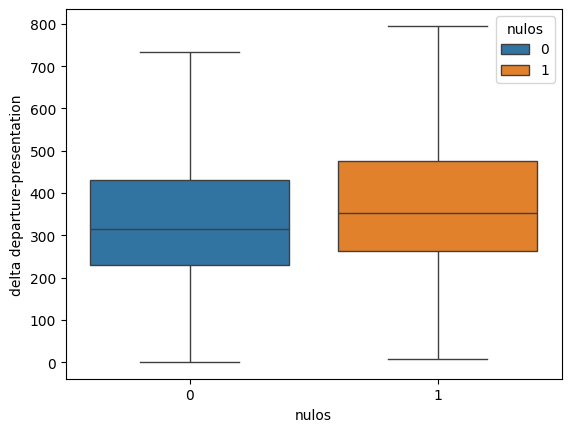

In [24]:
#Distribución de la variable respuesta en registros con y sin valores nulos en "location of the event"
df['nulos'] = np.where(df['location of the event'].isna(),1,0)

sns.boxplot(x = 'nulos' , y = 'delta departure-presentation',
            hue='nulos', data = df,
            showfliers=False)
plt.show()

La siguiente celda de código ejemplifica cómo la distribución de la etiqueta sería la misma si los errores fueran aleatorios.
(Descomenta las líneas y observa las diferencias con los resultados anteriores)

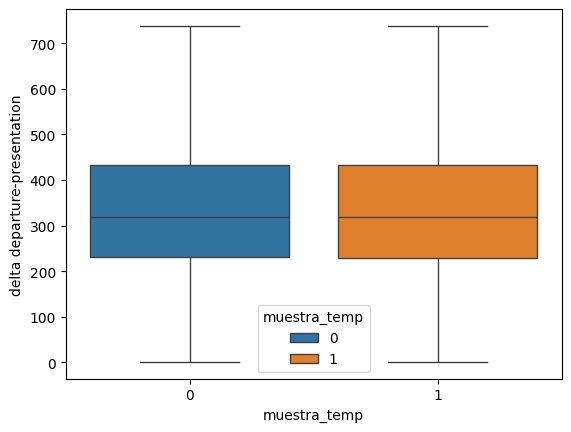

In [25]:
# # Creamos una Serie boleana de mismo tamaño que el dataset simulando nulos distribuidos uniformemente.

tam_muestra = 12710
df['muestra_temp'] = np.where(df.index.isin(df.sample(tam_muestra).index), 1 ,0)

sns.boxplot(x = 'muestra_temp' , y = 'delta departure-presentation',
            hue= 'muestra_temp', data = df,
            showfliers=False)
plt.show()

In [26]:
moda = df['location of the event'].mode().values[0]
df['location of the event'] = df['location of the event'].infer_objects(copy=False).fillna(moda)

In [27]:
df['location of the event'].isna().sum()

np.int64(0)

In [28]:
# borrar las columnas nulos
df = df.drop('nulos', axis=1)

# regresar a otipo objeto
df['location of the event'] = df['location of the event'].astype('int').astype('object')

In [29]:
# # borar la columna muestra_temp, en caso de haberla usado
df = df.drop('muestra_temp', axis=1)

# One hot encoding variables categoricas

In [30]:
df[categoricas].nunique()

,0
alert reason category,9
location of the event,210
emergency vehicle type,75


¿Vale la pena considerar todas las categorias para el one hot encodig?

In [31]:
df_column = df['alert reason category']
porcentaje = 99

frecuencia = df_column.value_counts()
sum_acumulada = (df_column.value_counts()/len(df)*100).cumsum().round(2)
pareto_df = pd.DataFrame({'Frecuencia':frecuencia,
                          'Porcentje_acumulado':sum_acumulada,
                          'Limite': porcentaje})
pareto_df

,Frecuencia,Porcentje_acumulado,Limite
alert reason category,,,
3,176787,80.60,99
1,21270,90.30,99
9,7481,93.71,99
2,5705,96.31,99
6,4814,98.50,99
4,1221,99.06,99
7,901,99.47,99
5,781,99.83,99
8,377,100.00,99


In [32]:
pareto_df['Principales_categorias'] = np.where(
    (pareto_df['Limite'] <= pareto_df['Porcentje_acumulado']) &
    (pareto_df['Limite'].shift(1) <= pareto_df['Porcentje_acumulado'].shift(1)),
      0, 1)
pareto_df

,Frecuencia,Porcentje_acumulado,Limite,Principales_categorias
alert reason category,,,,
3,176787,80.60,99,1
1,21270,90.30,99,1
9,7481,93.71,99,1
2,5705,96.31,99,1
6,4814,98.50,99,1
4,1221,99.06,99,1
7,901,99.47,99,0
5,781,99.83,99,0
8,377,100.00,99,0


Categorias: 9
Categorias que hacen el 99%: 6
Principales categorías = [3, 1, 9, 2, 6, 4]


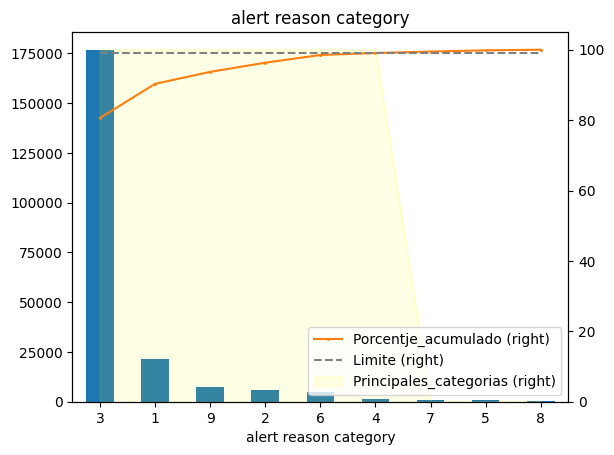

In [33]:
def categorias_utiles_pareto(df_column, porcentaje):
    # Data Frame con datos necesarios.
    frecuencia = df_column.value_counts()
    sum_acumulada = (df_column.value_counts()/len(df)*100).cumsum()
    pareto_df = pd.DataFrame({'Frecuencia':frecuencia,
                              'Porcentje_acumulado':sum_acumulada,
                              'Limite': porcentaje})

    # Obtención de categorías utiles.
    pareto_df['Principales_categorias'] = np.where(
    (pareto_df['Limite'] <= pareto_df['Porcentje_acumulado']) &             \
    (pareto_df['Limite'].shift(1) <= pareto_df['Porcentje_acumulado'].shift(1)),
      0, 100)
    principales_categorias = pareto_df[pareto_df['Principales_categorias']==100].index.to_list()

   # Imprimir información util.
    print(f'Categorias: {pareto_df.shape[0]}')
    print(f'Categorias que hacen el {porcentaje}%: {len(principales_categorias)}')
    print(f'Principales categorías = {principales_categorias}')


    # Gráfica de Pareto
    fig, axes = plt.subplots()
    ax1 = pareto_df.plot(use_index=True, y='Frecuencia',  kind='bar',
                         ax=axes, legend=False)
    ax2 = pareto_df.plot(use_index=True, y='Porcentje_acumulado', kind='line',
                         marker='D', ms=1, color="C1", ax=axes,
                         secondary_y=True, legend=False).legend(loc='lower right')
    axes.right_ax.set_ylim(0,105)
    ax3 = pareto_df.plot(use_index=True, y='Limite', color="gray", kind='line',
                         linestyle='dashed', ax=axes, secondary_y=True, legend=False).legend(loc='lower right')
    ax4 = pareto_df.plot(use_index=True, y='Principales_categorias',
                         color="yellow", kind='area', ax=axes,
                         secondary_y=True, alpha=0.1, legend=False).legend(loc='lower right')
    plt.title(f'{df_column.name}')

    return principales_categorias

cat_reason = categorias_utiles_pareto(df['alert reason category'], 99)

Categorias: 75
Categorias que hacen el 99%: 14
Principales categorías = ['VSAV BSPP', 'PSE', 'VLR BSPP', 'FPT BSPP', 'AR', 'FA', 'EPA BSPP', 'EPAN', 'CCR BSPP', 'CRF', 'FNPC', 'VID', 'BEAA BSPP', 'EPSA']


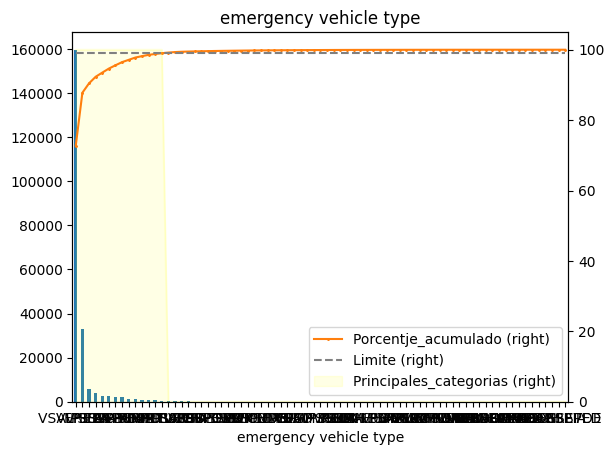

In [34]:
cat_vehicle = categorias_utiles_pareto(df['emergency vehicle type'], 99)

Categorias: 210
Categorias que hacen el 99%: 96
Principales categorías = [139, 136, 148, 149, 140, 107, 137, 131, 104, 325, 100, 259, 228, 241, 219, 135, 196, 105, 202, 210, 147, 224, 218, 199, 211, 257, 201, 226, 164, 232, 114, 216, 274, 323, 112, 143, 258, 138, 128, 111, 206, 205, 130, 222, 101, 244, 230, 233, 167, 108, 231, 229, 146, 118, 127, 134, 198, 220, 204, 227, 191, 270, 141, 115, 261, 264, 207, 212, 242, 286, 237, 121, 203, 106, 157, 113, 322, 179, 254, 316, 209, 260, 276, 125, 133, 189, 186, 320, 194, 263, 165, 221, 120, 236, 103, 208]


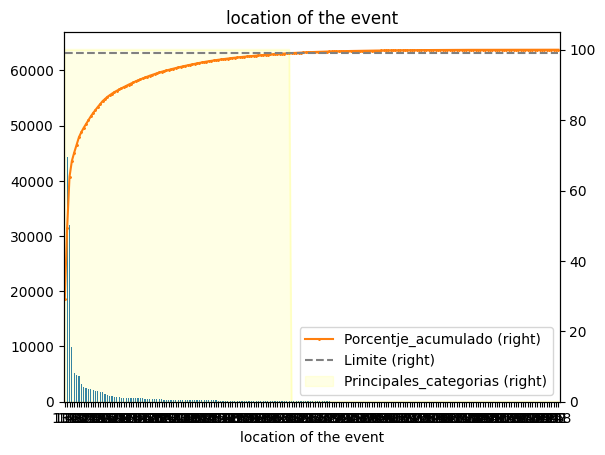

In [35]:
cat_location = categorias_utiles_pareto(df['location of the event'], 99)

In [36]:
describe_datos(df[categoricas])

,dtypes,null,nunique,unique
alert reason category,object,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
location of the event,object,0,210,"[148, 136, 139, 104, 157, 199, 140, 107, 325, ..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


In [37]:
df['alert reason category'] = np.where(df['alert reason category'].isin(cat_reason),
                                       df['alert reason category'], np.nan)
df['emergency vehicle type'] = np.where(df['emergency vehicle type'].isin(cat_vehicle),
                                       df['emergency vehicle type'], np.nan)
df['location of the event'] = np.where(df['location of the event'].isin(cat_location),
                                       df['location of the event'], np.nan)

# En la transformación previa de las variables categoricas, podríamos cambiar np.nan por 'other',
# pero de esta manera, la categoria a eliminar en get_dummies sería por default sera np.nan

describe_datos(df[categoricas])

,dtypes,null,nunique,unique
alert reason category,object,2059,6,"[3, 9, 6, 1, 2, nan, 4]"
location of the event,object,2189,96,"[148, 136, 139, 104, 157, 199, 140, 107, 325, ..."
emergency vehicle type,object,2166,14,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


In [38]:
he = pd.get_dummies(df[categoricas])
print(he.shape)
he.head()

(219337, 116)


,alert reason category_1,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_6,alert reason category_9,location of the event_100,location of the event_101,location of the event_103,location of the event_104,...,emergency vehicle type_EPA BSPP,emergency vehicle type_EPAN,emergency vehicle type_EPSA,emergency vehicle type_FA,emergency vehicle type_FNPC,emergency vehicle type_FPT BSPP,emergency vehicle type_PSE,emergency vehicle type_VID,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4720915,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
5365374,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4741586,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5381209,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [39]:
df.columns

Index(['selection time', 'alert reason category',
       'intervention on public roads', 'floor', 'location of the event',
       'emergency vehicle type', 'OSRM estimated distance',
       'OSRM estimated duration', 'delta departure-presentation', 'rush hour',
       'weekday'],
      dtype='object')

In [40]:
df.shape, he.shape

((219337, 11), (219337, 116))

In [41]:
df = df.drop(columns=categoricas)
df = pd.concat([df, he], axis=1)
df.shape

(219337, 124)

In [42]:
#Llevar la etiqueta hasta la ultima posición

df = df[[c for c in df if c != 'delta departure-presentation'] + ['delta departure-presentation']]
print(df.shape)
df.info()

(219337, 124)
<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Columns: 124 entries, selection time to delta departure-presentation
dtypes: bool(117), datetime64[ns](1), float64(2), int64(4)
memory usage: 37.9 MB


In [43]:
df.columns

Index(['selection time', 'intervention on public roads', 'floor',
       'OSRM estimated distance', 'OSRM estimated duration', 'rush hour',
       'weekday', 'alert reason category_1', 'alert reason category_2',
       'alert reason category_3',
       ...
       'emergency vehicle type_EPAN', 'emergency vehicle type_EPSA',
       'emergency vehicle type_FA', 'emergency vehicle type_FNPC',
       'emergency vehicle type_FPT BSPP', 'emergency vehicle type_PSE',
       'emergency vehicle type_VID', 'emergency vehicle type_VLR BSPP',
       'emergency vehicle type_VSAV BSPP', 'delta departure-presentation'],
      dtype='object', length=124)

In [44]:
boleanas=[]
for col in df.columns:
  if df[col].nunique()==2:
    boleanas.append(col)
df[boleanas]=df[boleanas].astype('bool')

# Exploración de las variables numéricas

# Eliminar variables no relevantes y redundantes

1. **No relevantes**: Análisis de correlación de las explicativas(X) con la etiqueta (y)


2. **Redundantes**: Análisis de correlación entre las variables explicativas (X)

In [45]:
numericas = list(df.select_dtypes(include=['int64', 'float64']).columns)
numericas

['floor',
 'OSRM estimated distance',
 'OSRM estimated duration',
 'delta departure-presentation']

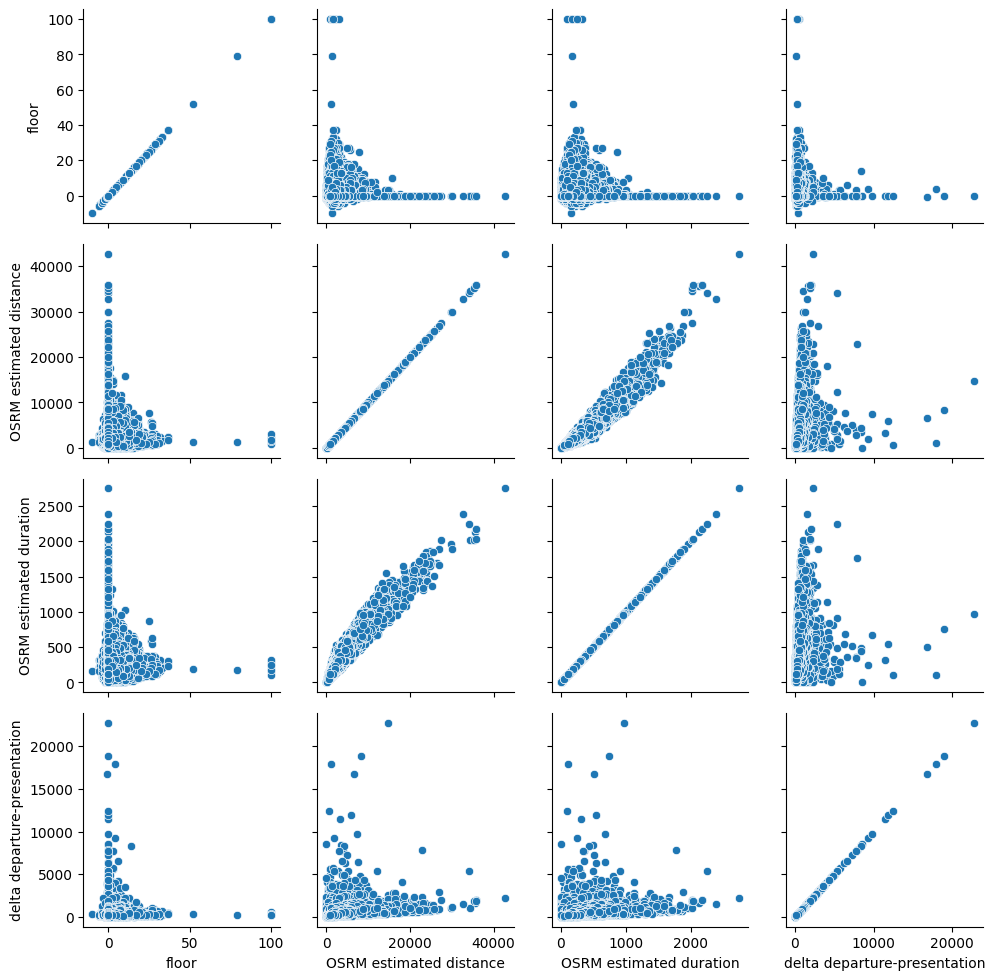

In [46]:
g = sns.PairGrid(df[numericas])
g.map(sns.scatterplot)

<h2> ¿Hay variables que no son relevantes para la predicción de la variable respuesta?

In [47]:
corr_y = df[numericas].corr()['delta departure-presentation']
corr_y

,delta departure-presentation
floor,0.002170
OSRM estimated distance,0.449922
OSRM estimated duration,0.446742
delta departure-presentation,1.000000


In [48]:
no_relevantes = corr_y.loc[corr_y.abs()<0.05].index.to_list()
no_relevantes

['floor']

<h2> ¿Hay variables redundantes entre las variables explicativas?

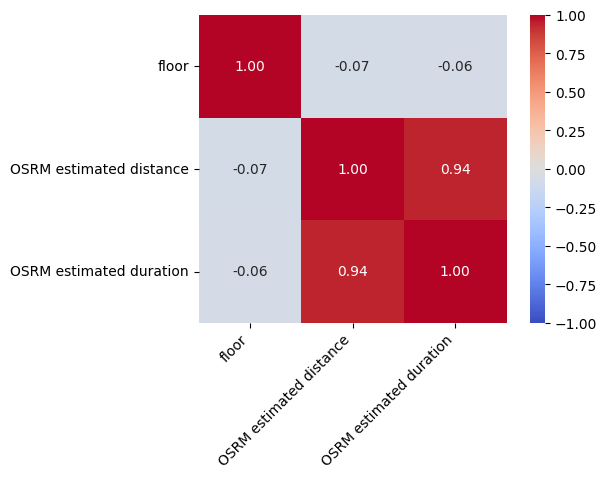

In [49]:
# correlacion de las características numéricas en el conjunto X
corr_matrix = correlacion(df[numericas[:3]])


In [50]:
#Identificar variables redundantes

# Triangulo superior de la matriz de correlación en números absolutos
celda_sobre_diagonal_ppal = np.triu(np.ones_like(corr_matrix), 1).astype(bool)
triangulo_sup = corr_matrix.where(celda_sobre_diagonal_ppal).abs()


# Encontrar las columnas donde la correlación es 1
redundantes = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
redundantes

['OSRM estimated duration']

In [51]:
df = df.drop(redundantes + no_relevantes, axis=1)

In [52]:
df.columns

Index(['selection time', 'intervention on public roads',
       'OSRM estimated distance', 'rush hour', 'weekday',
       'alert reason category_1', 'alert reason category_2',
       'alert reason category_3', 'alert reason category_4',
       'alert reason category_6',
       ...
       'emergency vehicle type_EPAN', 'emergency vehicle type_EPSA',
       'emergency vehicle type_FA', 'emergency vehicle type_FNPC',
       'emergency vehicle type_FPT BSPP', 'emergency vehicle type_PSE',
       'emergency vehicle type_VID', 'emergency vehicle type_VLR BSPP',
       'emergency vehicle type_VSAV BSPP', 'delta departure-presentation'],
      dtype='object', length=122)

# Exploración de la variable respuesta

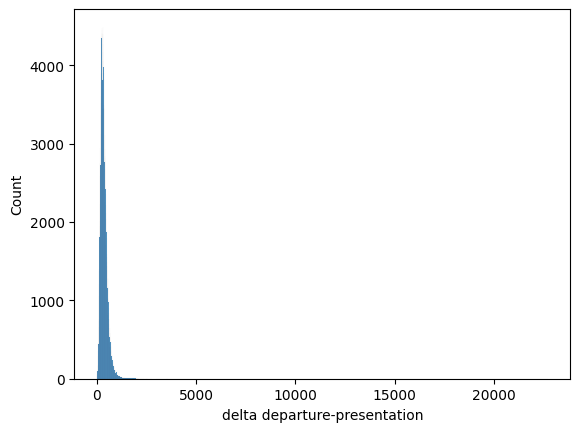

In [53]:
sns.histplot(df['delta departure-presentation'])
plt.show()

In [54]:
df['delta departure-presentation'].quantile(.975)

np.float64(806.0)

In [55]:
df['aux'] = (df['delta departure-presentation'] > df['delta departure-presentation'].quantile(.975)).astype(int)

<ipython-input-55-4b988271e6f9>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['aux'] = (df['delta departure-presentation'] > df['delta departure-presentation'].quantile(.975)).astype(int)


In [56]:
df['aux'].value_counts()

,count
aux,
0,213857
1,5480


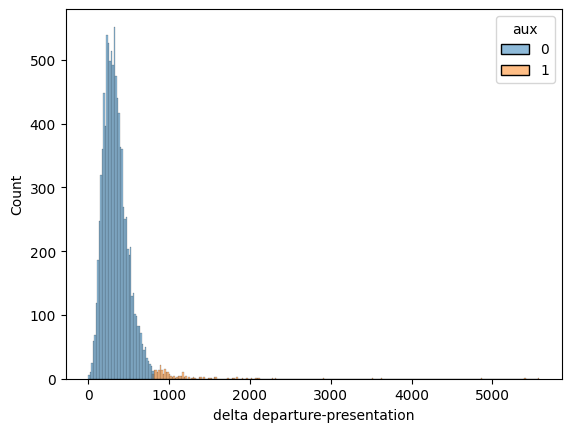

In [57]:
figsize=(12, 4)
muestra = df.sample(10000)
sns.histplot(x='delta departure-presentation', hue='aux', data=muestra )
plt.show()

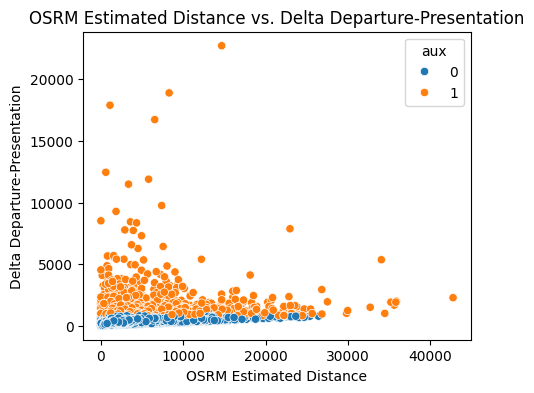

In [58]:
# @title
plt.figure(figsize=(5, 4))
sns.scatterplot(x='OSRM estimated distance',
                y='delta departure-presentation',
                hue='aux',
                data=df
                # data = df[df.aux==0].sample(5000)
)

plt.ylabel('Delta Departure-Presentation')
plt.xlabel('OSRM Estimated Distance')
plt.title('OSRM Estimated Distance vs. Delta Departure-Presentation')
plt.show()



In [59]:
seleccion = ((df['OSRM estimated distance']>20350) & (df['OSRM estimated distance']<20500))
df[seleccion].T

emergency vehicle selection,4808363,5320305,4832811
selection time,2018-02-15 10:58:51.493000,2018-10-25 16:32:40.670000,2018-02-28 17:44:03.653000
intervention on public roads,False,False,False
OSRM estimated distance,20451.1,20373.2,20420.9
rush hour,False,True,True
weekday,True,True,True
...,...,...,...
emergency vehicle type_VID,False,False,False
emergency vehicle type_VLR BSPP,False,True,True
emergency vehicle type_VSAV BSPP,False,False,False
delta departure-presentation,1171,609,1571


Revisa con atención los últimos dos registros mostrados

# Comparación Regresión lineal, Regresión robusta

In [60]:
y = df['delta departure-presentation']
X = df.drop(['selection time', 'delta departure-presentation', 'aux'],
            axis=1)

Guardamos datos preprocesados

In [ ]:
df_preprocesado = pd.concat([X,y], axis=1)
df_preprocesado.to_csv('/content/drive/MyDrive/Datos/ParisFireBrigade/Output/df_selec.csv')



In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=261)

In [65]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (153535, 120)
y:  (153535,)
Conjunto de prueba
X:  (65802, 120)
y:  (65802,)


## Regresión Lineal

In [63]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(y_test - y_pred ))
error_medio_absoluto

np.float64(107.28487711620288)

### Análisis de errores

In [66]:
#calculamos los errores
errores = (y_test - y_pred)
len(errores)

65802

Tenemos dos tipos de errores:


 1) Cuando la prediccción es mas alta que el valor real $ ~~~~\hat{y} > y $

 2) Cuando la predicción es más baja que el valor real $ ~~~~\hat{y} < y $



In [67]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal

print(f'kurtosis: {kurtosis(errores)}')


kurtosis: 1295.0594129606561


In [68]:
y_test.shape

(65802,)

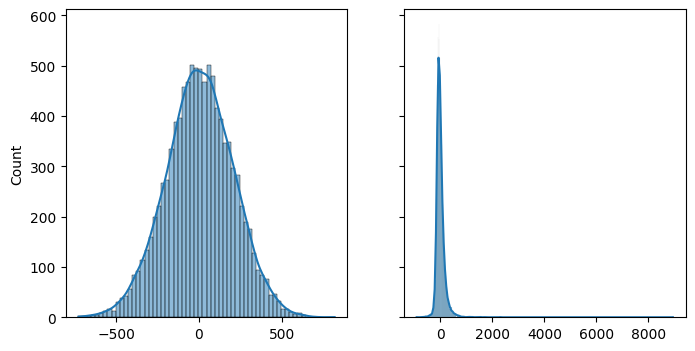

In [69]:
# Comparación de la distribución teórica(normal) y empirica de los errores

media = np.mean(errores)
des_est = np.std(errores)
errores_teoricos = np.random.normal(media, des_est, 10000)
muestra_errores = np.random.choice(errores, 10000)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, muestra_errores), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

## Regresión Robusta

In [64]:
hr = HuberRegressor(epsilon=1,   max_iter=1000,  alpha=0,  warm_start=False,
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, y_train)
y_pred_hr = hr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_hr))

MAE: 104.12003890593493


### Análisis de errores

In [70]:
#calculamos los errores
errores_hr = (y_test - y_pred_hr)

print(f'kurtosis: {kurtosis(errores_hr)}')

kurtosis: 1240.571585339878


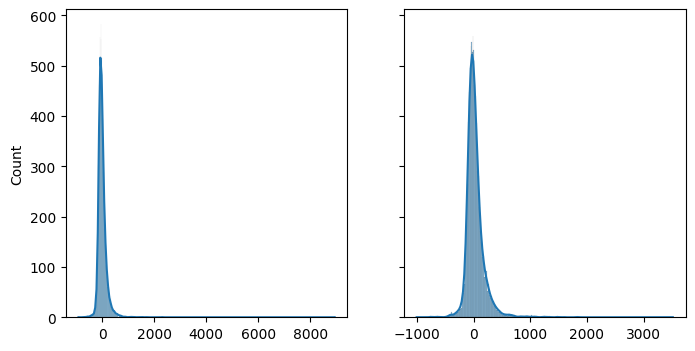

In [71]:
# Comparación de la distribución empirica de los errores de regresión lineal y regresión de hubber

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((muestra_errores,
                         np.random.choice(errores_hr,10000)), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

## Interpretación de los coeficientes

In [72]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(X.columns)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

,coef,variable
0,-28.347122,emergency vehicle type_AR
1,-15.562019,location of the event_325
2,-10.919870,location of the event_259
3,-10.747237,emergency vehicle type_CRF
4,-9.784235,intervention on public roads
...,...,...
115,28.463812,emergency vehicle type_FA
116,29.716479,alert reason category_9
117,34.762852,emergency vehicle type_PSE
118,41.971008,emergency vehicle type_FPT BSPP


<h3> Estandarizar valores para comparar importancia de variables

In [73]:
X_estandarizados = X.copy()
columnas = X.columns

scaler = StandardScaler()

X_estandarizados[columnas] = scaler.fit_transform(X[columnas])

In [74]:
X_estandarizados.describe()

,intervention on public roads,OSRM estimated distance,rush hour,weekday,alert reason category_1,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_6,alert reason category_9,...,emergency vehicle type_EPA BSPP,emergency vehicle type_EPAN,emergency vehicle type_EPSA,emergency vehicle type_FA,emergency vehicle type_FNPC,emergency vehicle type_FPT BSPP,emergency vehicle type_PSE,emergency vehicle type_VID,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
count,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,...,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05
mean,3.602327e-17,5.312784e-17,9.718507e-18,-1.130829e-16,3.508381e-17,-3.242742e-17,1.058669e-16,-4.353891e-17,-2.747098e-17,5.183204e-18,...,-1.295801e-17,-4.431639e-17,-3.271897e-18,2.944708e-17,-4.072055e-17,1.956659e-17,-2.290328e-17,-1.218053e-17,8.422706e-19,3.443591e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.143257e-01,-1.405675e+00,-5.286634e-01,-2.518152e+00,-3.277009e-01,-1.634160e-01,-2.038334e+00,-7.481937e-02,-1.498015e-01,-1.879141e-01,...,-9.722710e-02,-9.510229e-02,-4.668485e-02,-1.079384e-01,-6.285003e-02,-1.381373e-01,-4.202827e-01,-6.080666e-02,-1.650993e-01,-1.634913e+00
25%,-4.143257e-01,-6.389835e-01,-5.286634e-01,3.971167e-01,-3.277009e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,-1.498015e-01,-1.879141e-01,...,-9.722710e-02,-9.510229e-02,-4.668485e-02,-1.079384e-01,-6.285003e-02,-1.381373e-01,-4.202827e-01,-6.080666e-02,-1.650993e-01,-1.634913e+00
50%,-4.143257e-01,-2.333023e-01,-5.286634e-01,3.971167e-01,-3.277009e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,-1.498015e-01,-1.879141e-01,...,-9.722710e-02,-9.510229e-02,-4.668485e-02,-1.079384e-01,-6.285003e-02,-1.381373e-01,-4.202827e-01,-6.080666e-02,-1.650993e-01,6.116533e-01
75%,-4.143257e-01,3.747483e-01,-5.286634e-01,3.971167e-01,-3.277009e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,-1.498015e-01,-1.879141e-01,...,-9.722710e-02,-9.510229e-02,-4.668485e-02,-1.079384e-01,-6.285003e-02,-1.381373e-01,-4.202827e-01,-6.080666e-02,-1.650993e-01,6.116533e-01
max,2.413560e+00,2.545460e+01,1.891563e+00,3.971167e-01,3.051563e+00,6.119350e+00,4.905967e-01,1.336552e+01,6.675501e+00,5.321580e+00,...,1.028520e+01,1.051499e+01,2.142022e+01,9.264543e+00,1.591089e+01,7.239175e+00,2.379351e+00,1.644557e+01,6.056960e+00,6.116533e-01


In [75]:

X_train, X_test, y_train, y_test = train_test_split(X_estandarizados, y, test_size=0.3,
                                                    shuffle=True, random_state=261)

In [76]:
hr_st = HuberRegressor( epsilon=1,   max_iter=1000,  alpha=0,  warm_start=False,
                    fit_intercept=True, tol=1e-05)
hr_st = hr.fit(X_train, y_train)

In [77]:
coeficientes_hr_st = pd.Series(hr_st.coef_, index= columnas)

coef_estand = pd.DataFrame(coeficientes_hr_st.sort_values())
coef_estand

,0
alert reason category_1,-15.881964
alert reason category_3,-14.982914
alert reason category_2,-8.695382
alert reason category_9,-5.778909
location of the event_325,-3.894968
...,...
emergency vehicle type_FPT BSPP,13.980087
emergency vehicle type_VID,15.758114
emergency vehicle type_VSAV BSPP,28.423888
emergency vehicle type_PSE,32.197442


# Referencias

* García, S., Luengo, J., & Herrera, F. (2015). Data Preprocessing in Data Mining. Intelligent Systems Reference Library. doi:10.1007/978-3-319-10247-4


* Hawkins, D. M. (1980). Identification of Outliers. Springer Netherlands. https://doi.org/10.1007/978-94-015-3994-4


* McDonald, A. (2021, septiembre 8). Using the missingno Python library to Identify and Visualise Missing Data Prior to Machine Learning. Medium. https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

* Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods. Computers & Electrical Engineering, 40(1), 16-28. https://doi.org/10.1016/j.compeleceng.2013.11.024


.


